# ベイズ分類器

ベイズ統計学における「ナイーブベイズ分類器」を使って、収集したデータから予想してみる。

* [データ収集](001_データ収集.ipynb)で収集したデータを使う。
* [データ加工](002_データ加工.ipynb)で加工済みとする。

In [1]:
import download
import process_data
import pandas as pd
df = download.get_db_data()
df = process_data.processing_data(df)
#display(df)

# 符号化

* チーム名・スタジアム名を符号化
* 勝ち・負け・引き分けを符号化
* 試合日を月のみ取得

In [2]:
home = pd.concat([df["ホーム"],df["アウェイ"]]).drop_duplicates().reset_index(drop=True).to_dict()
team_dict = {v:k for k, v in home.items()} # 辞書のキー・バリュー交換

In [3]:
tmp = [team_dict[df["ホーム"][i]] for i in range(len(df))]
df["home"] = tmp
tmp = [team_dict[df["アウェイ"][i]] for i in range(len(df))]
df["away"] = tmp
#display(df)

In [4]:
studium = df["スタジアム"].drop_duplicates().reset_index(drop=True).to_dict()
studium_dict = {v:k for k, v in studium.items()}

In [5]:
tmp = [studium_dict[df["スタジアム"][i]] for i in range(len(df))]
df["studium"] = tmp

勝敗はホームチームの勝ち(WIN)、負け(LOSE)、引き分け(DRAW)の三種類に符号化する。  
最終出力を獲得勝ち点で出力することを考え、WIN=3/DRAW=1/LOSE=0としておく。

カップ戦とかでPK戦の結果も含まれているが、PKは引き分けととらえることにする。

In [6]:
import re
import numpy as np
wdl = []
# win-draw-lose VゴールとかPKとかはTOTO予想に関係ないので無視
LOSE = 0
DRAW = 1
WIN = 3
OTHER = np.nan
for result in df["スコア"]:
    tmp = re.split("[-()]",result)
    if len(tmp) < 2: # X-Xという形式でないものはスルー
        wdl.append(OTHER)
        continue
    if int(tmp[0]) > int(tmp[1]):
        wdl.append(WIN)
    elif int(tmp[0]) < int(tmp[1]):
        wdl.append(LOSE)
    else:
        wdl.append(DRAW)
df["result"] = wdl
#display(df)

対戦した時期として、月の情報を入れるものとする。

試合日から情報を検出する。

In [7]:
month = []
for match_day in df["試合日"]:
    tmp = match_day.split("/")[0]
    if tmp.isdigit() == True:
        month.append(int(tmp))
    else:
        month.append(np.nan)
df["month"] = month
#display(month)

In [8]:
df = df.rename(columns={"年度":"year"})
#display(df)

使うデータを1992年~2016年に絞る。  
2017年のデータは予測の正確性検証のために別にしておくため

In [9]:
data = df[df["year"] < 2017]

結果の異常値を弾く。

異常値としてNaN(np.nan)を使ったので、NaNを含む列をドロップする。

In [10]:
data = data.dropna()

ホームチームを限定して、入力データと2017年のデータを使った正解データを生成してみる。

In [11]:
def generate_trainng_data(df, year=2017, home=None, away=None):
    """
    ホームチームを指定し、学習用データ(指定した年度より前のデータから)を生成
    """
    data = df[df["year"] < year].dropna()
    if home is not None and away is not None:
        data = data[((data["ホーム"]==home) | (data["アウェイ"]==home))|((data["ホーム"]==away) | (data["アウェイ"]==away))]
    x = data[["home","away","year","month","studium"]]
    y = data["result"]
    return x, y

def generate_correct_data(df, year=2017, home=None, away=None):
    """
    ホームチームを指定し、モデルの確からしさを検証するためのデータを生成
    """
    data = df[df["year"] == year].dropna()
    if home is not None and away is not None:
        data = data[((data["ホーム"]==home) | (data["アウェイ"]==home))|((data["ホーム"]==away) | (data["アウェイ"]==away))]
    x = data[["home","away","year","month","studium"]]
    y = data[["result"]]
    return x, y

## ナイーブベイズ分類器

[Scikit-Learn](http://scikit-learn.org/stable/modules/naive_bayes.html)で基本分布としてGaussian/Multinomial/Bernoulliを使うナイーブベイズ分類器が実装されているので、これらを利用してみる。

In [12]:
x, y = generate_trainng_data(df, 2017)

In [13]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

# モデルの学習
#model = GaussianNB()
#model = MultinomialNB()
model = BernoulliNB()
model.fit(x, y)
print("Model fitted.")

Model fitted.


In [14]:
# モデルから2017年の対戦データを予想し、predict列に表示
cx, cy = generate_correct_data(df,2017)
test_label = model.predict(cx)

In [15]:
predict = pd.concat([
    cx.reset_index(drop=True), 
    cy.reset_index(drop=True), 
    pd.DataFrame(test_label)],
    axis=1).rename(columns={0:"predict"})
display(predict)

,home,away,year,month,studium,result,predict
0,7,2,2017,2,95,3,3
1,5,19,2017,2,6,0,3
2,0,22,2017,2,22,0,3
3,17,18,2017,2,55,3,3
4,4,24,2017,2,25,1,3
5,16,12,2017,2,53,0,3
6,13,10,2017,2,52,1,3
7,25,20,2017,2,2,0,3
8,3,21,2017,2,127,1,3
9,32,42,2017,2,79,3,3


In [16]:
len(predict[predict["result"]==predict["predict"]])/len(predict)

0.41742286751361163

一番良い結果が得られたBernoulli分布に基づく分類器でも、全体としては41.7%という結果。

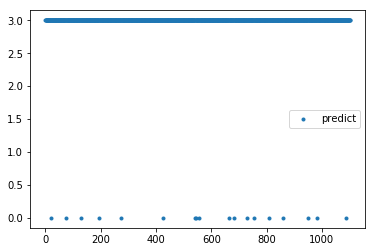

In [21]:
%matplotlib inline
predict.plot(y=["predict"],style=".")